In [1]:
from scipy.io import netcdf
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
import numpy as np
import calculations as calc
import similarity_measures

In [2]:
nc_l30 = netcdf.netcdf_file("data/era-int_pl_1979-2019-mm-l30-u.nc")

<h3>QBO Index used</h3>
Values at +- 5°north and south of the equator at pressure level 30 hPa.
Different QBO Indices presented in <a href="3_deriving_QBO.ipynb">Notebook 3<a>

In [3]:
lon = calc.convert_coordinates_to_grid(nc_l30.variables["longitude"][:], 180)
lat = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 0)

lon_step = 256 #Around the whole equator
lat_step = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 5)

u_l30 = nc_l30.variables["u"]

#Deseasonalize
u_l30 = calc.deseasonalize_map(u_l30)

qbo_equator = calc.derive(u_l30[:, :, :, :], lat, lon, 0, lat_step, lon_step)

<h2>Similarity measures used</h2>
$f_t^p, f_t^q: Time series$
<h3>1. Pearson's Correlation</h3>
    Quantifies the degree of linear relationship between time series
    $D_{CC}=\frac{\sum_{t=0}^{N-1}((f_t^p-\overline{f^p})\ast(f_{t-s}^q-\overline{f^q}))}{\sqrt{\sum_{t=0}^{N-1}(f_{t-s}^p-\overline{f^p})^2}\ast\sqrt{\sum_{t=0}^{N-1}(f_{t-s}^q-\overline{f^q})^2}}$
    
    
<h3>2. Mutual Information</h3>
Measure of the amount of mutual dependence between two random variables
        $MI(f^p, f^q)= -\sum_{f_i^p,f_i^q}p(f_i^p,f_i^q)log_2\frac{p(f_i^p,f_i^q)}{p(f_i^p)p(f_i^q)}$</li>
<ol>


In [4]:
print(similarity_measures.correlation_similarity.__doc__)


    Compute the Pearson correlation coefficient between two series

    Quantifies the degree of linear relationship between time series.

    Args:
        series1 (numpy.ndarray): First series
        series2 (numpy.ndarray): Second series

    Returns:
        Pearson correlation coefficient between the two series
    


In [5]:
print(similarity_measures.mutual_information.__doc__)


    Compute the Mutual Information between two series

    Measure of the amount of mutual dependence between two random variables.

    Args:
        series1 (numpy.ndarray): First series
        series2 (numpy.ndarray): Second series

    Returns:
        Mutual Information between the two series
    


In [6]:
#Create Mappers for colorbars
norm_correlation = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
mapper_correlation = matplotlib.cm.ScalarMappable(norm=norm_correlation)

norm_mutual_information = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper_mutual_information = matplotlib.cm.ScalarMappable(norm=norm_mutual_information, cmap="YlOrRd")

<h3>1. Plot similarity for the whole period (40 years) </h3>

In [7]:
print(calc.calculate_series_similarity.__doc__)


    Calculate similarity of all points on a map to a reference series

    Args:
        map_array (numpy.ndarray): Map with 4 dimensions - time, level, latitude, longitude
        referenceSeries (numpy.ndarray): 1 dimensional reference series
        level (int, optional): Level on which the similarity should be calculated
            Defaults to 0
        sim_func (str, optional): The similarity function that should be used.
            Defaults to Pearon's Correlation Coefficient.

    Returns:
        2 dimensional numpy.ndarray with similarity values to reference point
    


Calculate similarity

In [9]:
sim_whole_period_correlation = calc.calculate_series_similarity(u_l30[:480, :, :, :], qbo_equator, level=0, sim_func=similarity_measures.correlation_similarity)
sim_whole_period_mutual_information = calc.calculate_series_similarity(u_l30[:480, :, :, :], qbo_equator, level=0, sim_func=similarity_measures.mutual_information)

Plotting

C:\Users\tousp\anaconda3\envs\climate_similarity_measures\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
C:\Users\tousp\anaconda3\envs\climate_similarity_measures\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


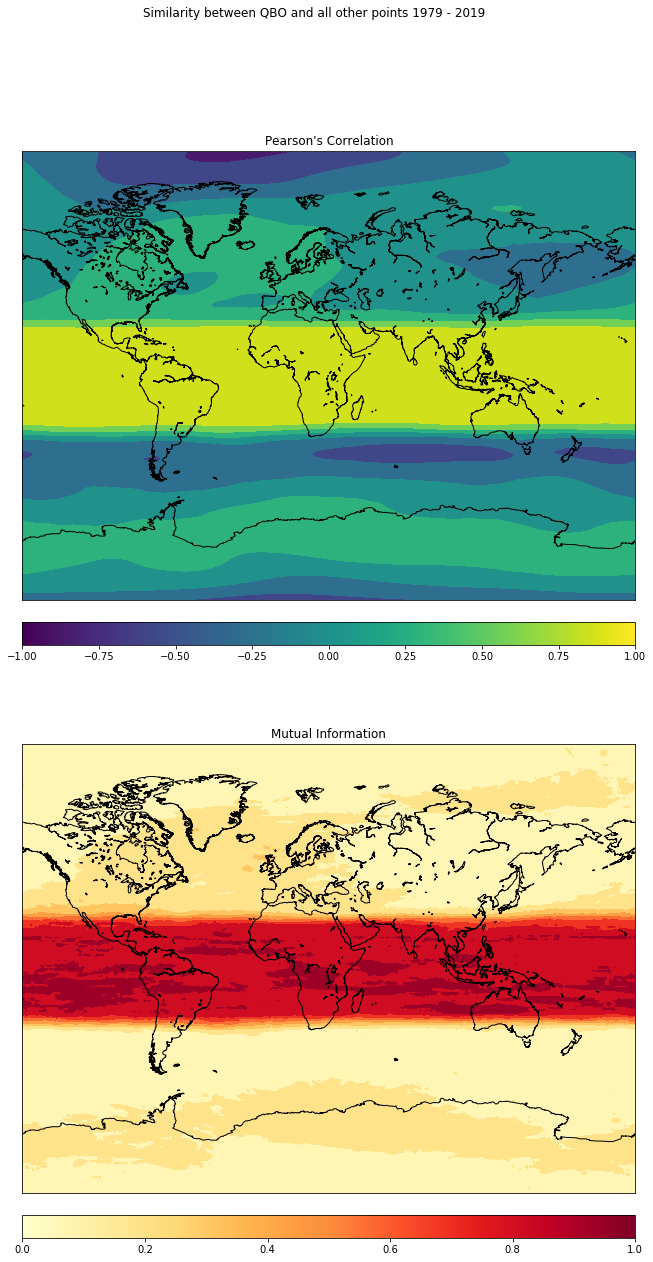

In [10]:
fig, ax =plt.subplots(2, figsize = (16,20))

#Correlation Map
m = Basemap(projection='mill',lon_0=30,resolution='l', ax=ax[0])
m.drawcoastlines()
lons, lats = m.makegrid(512, 256)
x, y = m(lons, lats)
cs = m.contourf(x, y, sim_whole_period_correlation[:, :])
cbar = m.colorbar(mapper_correlation,location='bottom',pad="5%")


#Mutual Information Map
m = Basemap(projection='mill',lon_0=30,resolution='l', ax=ax[1])
m.drawcoastlines()
cs = m.contourf(x, y, sim_whole_period_mutual_information[:, :], cmap="YlOrRd")
cbar = m.colorbar(mapper_mutual_information,location='bottom',pad="5%")


ax[0].set_title("Pearson's Correlation")
ax[1].set_title("Mutual Information")
fig.suptitle("Similarity between QBO and all other points 1979 - 2019")
plt.show()

<h3>2. Plot similarity for the whole period, but for every month separately</h3>

In [11]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

In [ ]:
fig, ax = plt.subplots(figsize=(15,60), nrows=12, ncols=2)
fig.subplots_adjust(hspace=0, wspace=0)

for month in range(len(months)):
    ax[month][0].set_ylabel(months[month])
    
    #Extract monthly values
    u_l30_month = np.array([u_l30[12 * i + month,:,:,:] for i in range(40)])
    qbo_equator_month = [qbo_equator[12 * i + month] for i in range(40)]
    
    
    #Calculate similarities
    month_similarity_correlation = calc.calculate_series_similarity(u_l30_month[:][:,:,:,:], qbo_equator_month[:], level=0, sim_func=similarity_measures.correlation_similarity)
    month_similarity_mutual_information =calc.calculate_series_similarity(u_l30_month[:][:,:,:,:], qbo_equator_month[:], level=0, sim_func=similarity_measures.mutual_information)
    
    
    #Plot Correlation Map
    m = Basemap(projection='mill',lon_0=30,resolution='l', ax=ax[month][0])
    m.drawcoastlines()
    lons, lats = m.makegrid(512, 256)
    x, y = m(lons, lats)
    cs = m.contourf(x, y, month_similarity_correlation[:, :])
    
    #Plot Mutual Information Map    
    m = Basemap(projection='mill',lon_0=30,resolution='l', ax=ax[month][1])
    m.drawcoastlines()
    cs = m.contourf(x, y, month_similarity_mutual_information[:, :], cmap="YlOrRd")
    

plt.colorbar(mapper_correlation, cax=plt.axes([0, 0.4, 0.045, 0.2]))
plt.colorbar(mapper_mutual_information, cax=plt.axes([1, 0.4, 0.045, 0.2]))
ax[0][0].set_title("Pearson's Correlation")
ax[0][1].set_title("Mutual Information")
fig.suptitle("Similarity between QBO and all other points 1979 - 2019")
plt.show()
    

C:\Users\tousp\anaconda3\envs\climate_similarity_measures\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tousp\anaconda3\envs\climate_similarity_measures\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<h3>3. For the whole period, but only for the winter months combined (December, January, February)</h3>

In [ ]:
winter_indices = []
for i in range(40):
    year = 12 * i
    winter_indices.append(year) #January
    winter_indices.append(year + 1) #February 
    winter_indices.append(year + 11) #December 

Extract winter values

In [ ]:
qbo_equator_winter = np.array(qbo_equator)[winter_indices]
u_l30_winter = np.array(u_l30[:])[winter_indices, :, :, :]

Calculate similarity

In [ ]:
sim_winter_correlation = calc.calculate_series_similarity(u_l30_winter[:,:,:,:], qbo_equator_winter[:], level=0, sim_func=similarity_measures.correlation_similarity)
sim_winter_mutual_information = calc.calculate_series_similarity(u_l30_winter[:,:,:,:], qbo_equator_winter[:], level=0, sim_func=similarity_measures.mutual_information)

Plotting

In [ ]:
fig, ax = plt.subplots(2, figsize = (16,20))

#Correlation Map
m = Basemap(projection='mill',lon_0=30,resolution='l', ax=ax[0])
m.drawcoastlines()
lons, lats = m.makegrid(512, 256)
x, y = m(lons, lats)
cs = m.contourf(x, y, sim_winter_correlation[:, :])
cbar = m.colorbar(mapper_correlation,location='bottom',pad="5%")


#Mutual Information Map
m = Basemap(projection='mill',lon_0=30,resolution='l', ax=ax[1])
m.drawcoastlines()
cs = m.contourf(x, y, sim_winter_mutual_information[:, :], cmap="YlOrRd")
cbar = m.colorbar(mapper_mutual_information,location='bottom',pad="5%")

ax[0].set_title("Pearson's Correlation")
ax[1].set_title("Mutual Information")
fig.suptitle("Similarity between QBO and all other points for winter months 1979 - 2019")
plt.show()